### Human In the Loop
Review
For human-in-the-loop, we often want to see our graph outputs as its running.

We laid the foundations for this with streaming.

Goals
Now, let's talk about the motivations for human-in-the-loop:

(1) Approval - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) Debugging - We can rewind the graph to reproduce or avoid issues

(3) Editing - You can modify the state

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.

In [64]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

In [101]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="qwen-qwq-32b",
)

In [102]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

llm_with_tools=llm.bind_tools(tools)

In [103]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

system_message = SystemMessage(
    content="You are a helpful assistant that can perform arithmetic operations."
)

def assistant(state: MessagesState):
  return {'messages': llm_with_tools.invoke([system_message] + state['messages'])}

In [128]:
# Graph

builder = StateGraph(MessagesState)

builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'assistant')
builder.add_conditional_edges('assistant', tools_condition)

builder.add_edge('tools', 'assistant')

memory = MemorySaver()

graph = builder.compile(interrupt_before=['assistant'], checkpointer= memory)



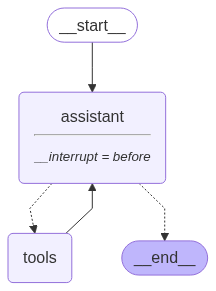

In [129]:
graph

In [130]:
initial_input = {'messages': [HumanMessage(content="What is 2 * 2?")]}
thread = {'configurable': {'thread_id': 1}}

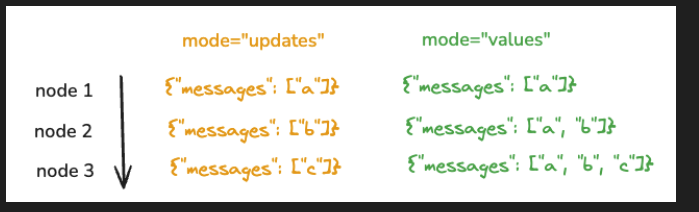

In [131]:
for event in graph.stream(initial_input,thread, stream_mode='values'):
  event['messages'][-1].pretty_print()
    

================================ Human Message =================================

What is 2 * 2?


In [132]:
current_graph_state = graph.get_state(thread)
current_graph_state.next

('assistant',)

In [133]:
for event in graph.stream(None, thread, stream_mode='values'):
  event['messages'][-1].pretty_print()


================================ Human Message =================================

What is 2 * 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_19ks)
 Call ID: call_19ks
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


### till now we were not passing anything as a human feedback but now we will pass human feedback

In [134]:
initial_input = {'messages': [HumanMessage(content="What is 2 + 2?")]}

thread = {'configurable': {'thread_id': '1'}}
for event in graph.stream(initial_input, thread, stream_mode='values'):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

What is 2 + 2?


In [135]:
graph.update_state(thread,{"messages":[HumanMessage(content="No, actually multiply 15 and 5!")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03702f-fa0e-6094-8001-3cc6b93b7457'}}

In [136]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
  m.pretty_print()

================================ Human Message =================================

What is 2 + 2?
================================ Human Message =================================

No, actually multiply 15 and 5!


In [137]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 15 and 5!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_mj2x)
 Call ID: call_mj2x
  Args:
    a: 15
    b: 5
================================= Tool Message =================================
Name: multiply

75


In [139]:
state=graph.get_state(thread)
state.next

('assistant',)

In [140]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

75
================================== Ai Message ==================================

<answer>75</answer>


## Taking input from user

In [150]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [151]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

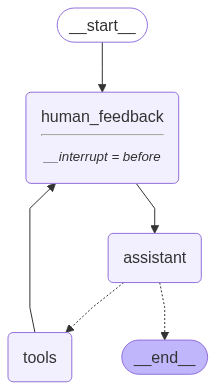

In [152]:
graph

In [153]:
initial_input = {'messages': [HumanMessage(content="What is 2 + 2?")]}

thread = {'configurable': {'thread_id': '3'}}

for event in graph.stream(initial_input, thread, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

What is 2 + 2?


In [154]:
## get user input

user_input=input("Tell me how you want to update the state:")

graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03706c-293f-675a-8001-27145be49e2b'}}

In [155]:
for event in graph.stream(None, thread, stream_mode='values'):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

divide them dont add
================================== Ai Message ==================================
Tool Calls:
  divide (call_12d6)
 Call ID: call_12d6
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: divide

1.0


In [156]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: divide

1.0
================================== Ai Message ==================================

The result of dividing 2 by 2 is indeed 1.0. Let me know if you need further assistance!
